# Superset Dataset Export

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%run -m ipy_plotly
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type
from mgds.data_aggregation import io_utils as io
from mgds.data_aggregation import entity
from mgds.data_aggregation import api as mgds_api
from mgds.data_aggregation.export_lib import sql_export
from py_utils import set_utils, collection_utils, assertion_utils
pd.set_option('display.max_info_rows', 50000000)

2016-12-11 08:12:07,404:INFO:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


## Entity Mappings

In [2]:
d_id = mgds_api.get_entity_mapping(entity.CELL_LINE)
d_id.head()

TAXONOMY                          COMMON                                 \
SOURCE                           ccle_v1                                  
DATA_TYPE                  cellline-meta               gene-copy-number   
MGDS_ID                                                                   
1321N1     1321N1_CENTRAL_NERVOUS_SYSTEM  1321N1_CENTRAL_NERVOUS_SYSTEM   
143B                           143B_BONE                      143B_BONE   
184A1                               None                           None   
184B5                               None                           None   
2004                                None                           None   

TAXONOMY                                                                  \
SOURCE                                                            ctd_v2   
DATA_TYPE gene-exome-seq                gene-expression drug-sensitivity   
MGDS_ID                                                                    
1321N1              None  1321N1_CENTRAL_NERVOUS_SYSTEM             None   
143B                None                      143B_BONE             None   
184A1               None                           None             None   
184B5               None                           None             None   
2004                None                           None             2004   

TAXONOMY                                                                  \
SOURCE          gdsc_v2                                                    
DATA_TYPE cellline-meta drug-sensitivity gene-copy-number gene-exome-seq   
MGDS_ID                                                                    
1321N1             None             None             None           None   
143B               None             None             None           None   
184A1              None             None             None           None   
184B5              None             None             None           None   
2004               None             None             None           None   

TAXONOMY                        ...                                        \
SOURCE                          ...           ncidream_v1                   
DATA_TYPE gene-expression       ...        gene-exome-seq gene-expression   
MGDS_ID                         ...                                         
1321N1               None       ...                  None            None   
143B                 None       ...                  None            None   
184A1                None       ...                 184A1            None   
184B5                None       ...                 184B5           184B5   
2004                 None       ...                  None            None   

TAXONOMY                                       COSMIC                   \
SOURCE                                        gdsc_v2                    
DATA_TYPE gene-methylation gene-rna-seq cellline-meta drug-sensitivity   
MGDS_ID                                                                  
1321N1                None         None          None             None   
143B                  None         None          None             None   
184A1                 None        184A1          None             None   
184B5                 None        184B5          None             None   
2004                  None         None          None             None   

TAXONOMY                                                               CTD  
SOURCE                                                              ctd_v2  
DATA_TYPE gene-copy-number gene-exome-seq gene-expression drug-sensitivity  
MGDS_ID                                                                     
1321N1                None           None            None             None  
143B                  None           None            None             None  
184A1                 None           None            None             None  
184B5                 None           None            N

In [3]:
d_ps = mgds_api.get_entity_mapping(entity.PRIMARY_SITE)
d_ps.head()

,SOURCE,ccle_v1,gdsc_v2,nci60_v2,ncidream_v1
CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,,,,
1321N1,CENTRAL_NERVOUS_SYSTEM,CENTRAL_NERVOUS_SYSTEM,None,None,None
143B,BONE,BONE,None,None,None
184A1,BREAST,None,None,None,BREAST
184B5,BREAST,None,None,None,BREAST
201T,LUNG,None,LUNG,None,None


In [4]:
d_rx = mgds_api.get_entity_mapping(entity.DRUG)
d_rx.head()

TAXONOMY                                 BROAD COMMON          \
SOURCE                                  ctd_v2 ctd_v2 gdsc_v2   
DRUG_NAME:MGDS                                                  
010200                                    None   None    None   
1011METHYLENEDIOXY20RSCAMPTOTHECIN        None   None    None   
1011METHYLENEDIOXYCAMPTOTHECIN            None   None    None   
1024DICHLOROPHENYL3METHYLFLAVIN           None   None    None   
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM   None   None    None   

TAXONOMY                                                                               \
SOURCE                                                                       nci60_v2   
DRUG_NAME:MGDS                                                                          
010200                                                                         010200   
1011METHYLENEDIOXY20RSCAMPTOTHECIN           10,11-methylenedioxy-20(rs)-camptothecin   
1011METHYLENEDIOXYCAMPTOTHECIN                       10,11-methylenedioxycamptothecin   
1024DICHLOROPHENYL3METHYLFLAVIN              10-(2',4'-dichlorophenyl)-3-methylflavin   
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM  10-(6'-ubiquinolyl)decyltriphenylphosphonium   

TAXONOMY                                             COSMIC    CTD      NSC  \
SOURCE                                  ncidream_v1 gdsc_v2 ctd_v2 nci60_v2   
DRUG_NAME:MGDS                                                                
010200                                         None    None   None   529108   
1011METHYLENEDIOXY20RSCAMPTOTHECIN             None    None   None   606174   
1011METHYLENEDIOXYCAMPTOTHECIN                 None    None   None   634724   
1024DICHLOROPHENYL3METHYLFLAVIN                None    None   None   625537   
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM        None    None   None   745025   

TAXONOMY                                     PUBCHEM  
SOURCE                                      nci60_v2  
DRUG_NAME:MGDS                                        
010200                                        482905  
1011METHYLENEDIOXY20RSCAMPTOTHECIN            580568  
1011METHYLENEDIOXYCAMPTOTHECIN                497235  
1024DICHLOROPHENYL3METHYLFLAVIN               492471  
106UBIQUINOLYLDECYLTRIPHENYLPHOSPHONIUM  9.11476e+07

In [5]:
# d_rx[d_rx['COMMON']['ncidream_v1'].notnull()]

## Load Drug Sensitivity Data

In [6]:
taxonomy = 'COMMON'
src_typs = d_rx[taxonomy].columns.values
srcs = np.unique(d_rx[taxonomy].columns.get_level_values('SOURCE'))
mappings={entity.CELL_LINE: d_id, entity.PRIMARY_SITE: d_ps, entity.DRUG: d_rx}
srcs

array(['ctd_v2', 'gdsc_v2', 'nci60_v2', 'ncidream_v1'], dtype=object)

In [7]:
d_drug = mgds_api.get_drug_sensitivity_data(srcs, mappings=mappings)
d_drug['EXPERIMENT_ID'] = d_drug['EXPERIMENT_ID'].astype(str)
assert np.all(d_drug['DRUG_NAME:MGDS'].notnull())
d_drug = d_drug[d_drug['CELL_LINE_ID:MGDS'].notnull()]
d_drug.head()

2016-12-11 08:12:08,986:WARNING:mgds.data_aggregation.api: Genomic data for source "ctd_v2" and data type "drug-sensitivity" has a cell line mapping but does not have a primary site mapping (so all primary site fields will be null)


,ACTION,AUC,CELL_LINE_ID,CELL_LINE_ID:COSMIC,CELL_LINE_ID:CTD,CELL_LINE_ID:MGDS,DRUG_ID:BROAD,DRUG_ID:COSMIC,DRUG_ID:CTD,DRUG_ID:NSC,...,PRIMARY_SITE:MGDS,PRIMARY_SITE:SOURCE,REPLICATE_COUNT,RMSE,SMILES,SOURCE,STATUS,SYNONYMS,TARGET,TARGET_PATHWAY
0,NaN,14.782,CAS1,NaN,130.0,CAS1,BRD-K46556387,NaN,1788.0,NaN,...,None,None,NaN,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,ctd_v2,probe,NaN,NaN,NaN
1,NaN,13.327,CAS1,NaN,130.0,CAS1,BRD-K86574132,NaN,3588.0,NaN,...,None,None,NaN,NaN,CC(C)N1C(=O)S\C(=C\c2ccc(Sc3nc4ccccc4[nH]3)o2)...,ctd_v2,probe,NaN,NaN,NaN
2,NaN,16.082,CAS1,NaN,130.0,CAS1,BRD-K35716340,NaN,12877.0,NaN,...,None,None,NaN,NaN,C(Cn1c2ccccc2c2ccccc12)c1nc2ccccc2[nH]1,ctd_v2,probe,NaN,NaN,NaN
3,NaN,13.743,CAS1,NaN,130.0,CAS1,BRD-K89329876,NaN,19153.0,NaN,...,None,None,NaN,NaN,CC(C)(C)c1ccc2cc(C#N)c(cc2c1)C#N,ctd_v2,probe,NaN,NaN,NaN
4,NaN,13.390,CAS1,NaN,130.0,CAS1,BRD-K45401373,NaN,23256.0,NaN,...,None,None,NaN,NaN,CC(=C)[C@@H]1CC[C@@]2(CC[C@]3(C)[C@H](CC[C@@H]...,ctd_v2,probe,NaN,NaN,NaN


In [8]:
d_drug.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488660 entries, 0 to 1140
Data columns (total 33 columns):
ACTION                 433297 non-null object
AUC                    600411 non-null float64
CELL_LINE_ID           1488660 non-null object
CELL_LINE_ID:COSMIC    205148 non-null object
CELL_LINE_ID:CTD       395263 non-null float64
CELL_LINE_ID:MGDS      1488660 non-null object
DRUG_ID:BROAD          395263 non-null object
DRUG_ID:COSMIC         205148 non-null float64
DRUG_ID:CTD            395263 non-null float64
DRUG_ID:NSC            887108 non-null float64
DRUG_ID:PUBCHEM        818965 non-null float64
DRUG_NAME              1488660 non-null object
DRUG_NAME:MGDS         1488660 non-null object
DRUG_NAME:SOURCE       1488660 non-null object
EXPERIMENT_ID          1488660 non-null object
FDA_STATUS             389856 non-null object
GI50_ZSCORE            887108 non-null float64
IC50_RESULTS_ID        205148 non-null object
LN_GI50                888249 non-null float64
LN

In [12]:
d_drug.groupby('DRUG_NAME:MGDS')['SOURCE'].nunique().value_counts()

1    4705
2     108
3      35
4       2
Name: SOURCE, dtype: int64

In [10]:
d_drug['DRUG_NAME:MGDS'].nunique()

4850

### Statistics and Aggregation

In [13]:
d_drug_exp = d_drug.copy()

# Helptul column sets for grouping and filtering
c_val = ['LN_GI50', 'LN_IC50', 'LOG2_EC50', 'AUC', 'GI50_ZSCORE']
c_grp = ['CELL_LINE_ID:MGDS', 'SOURCE', 'DRUG_NAME:MGDS']
c_grp_lng = c_grp + ['UNIT']
c_meta = [
    'PRIMARY_SITE:MGDS', 'DRUG_NAME:SOURCE', 'FDA_STATUS', 
    'TARGET', 'TARGET_PATHWAY', 'EXPERIMENT_ID', 'SOURCE_N'
]

# Add number of unique sources per drug (convenient for filtering later on)
d_source_ct = d_drug_exp.groupby('DRUG_NAME:MGDS')['SOURCE'].nunique().rename('SOURCE_N').reset_index()
n_before = len(d_drug_exp)
d_drug_exp = pd.merge(d_drug_exp, d_source_ct, on='DRUG_NAME:MGDS', how='inner')
assert n_before == len(d_drug_exp)
assert np.all(d_drug_exp['SOURCE_N'].notnull())
del d_source_ct

# Remove unnecessary meta data fields by selecting only those known to be useful
d_drug_exp = d_drug_exp[c_val + c_grp + c_meta]

# Melt replicate data measurements into rows instead of separate columns
id_vars = list(d_drug_exp.columns.difference(c_val))
d_drug_lng = pd.melt(d_drug_exp, id_vars=id_vars, var_name='UNIT', value_name='VALUE')
d_drug_lng = d_drug_lng[d_drug_lng['VALUE'].notnull()]
d_drug_lng.head()

,CELL_LINE_ID:MGDS,DRUG_NAME:MGDS,DRUG_NAME:SOURCE,EXPERIMENT_ID,FDA_STATUS,PRIMARY_SITE:MGDS,SOURCE,SOURCE_N,TARGET,TARGET_PATHWAY,UNIT,VALUE
4479,SF268,GOSSYPOL,(+/-)-gossypol,9104RC87,NaN,CENTRAL_NERVOUS_SYSTEM,nci60_v2,2,NaN,NaN,LN_GI50,-12.572115
4480,SF268,GOSSYPOL,(+/-)-gossypol,9108NS95,NaN,CENTRAL_NERVOUS_SYSTEM,nci60_v2,2,NaN,NaN,LN_GI50,-12.848425
4481,SF295,GOSSYPOL,(+/-)-gossypol,9104RC87,NaN,CENTRAL_NERVOUS_SYSTEM,nci60_v2,2,NaN,NaN,LN_GI50,-12.641192
4482,SF295,GOSSYPOL,(+/-)-gossypol,9108NS95,NaN,CENTRAL_NERVOUS_SYSTEM,nci60_v2,2,NaN,NaN,LN_GI50,-13.262890
4483,SF539,GOSSYPOL,(+/-)-gossypol,9104RC87,NaN,CENTRAL_NERVOUS_SYSTEM,nci60_v2,2,NaN,NaN,LN_GI50,-13.285916


In [14]:
# Compute some top line statistics for measure values across each cell line + drug + source combination
assert np.all(d_drug_lng[c_grp_lng].notnull())
d_drug_cl = d_drug_lng.groupby(c_grp_lng)['VALUE']\
    .agg({'MEAN': 'mean', '50P': 'median', 'STD': 'std', 'N': 'count'})
    
# Fill in missing STD for single replicates and assert nothing is null
d_drug_cl['STD'] = d_drug_cl['STD'].fillna(0)
assert np.all(d_drug_cl.notnull())

# Reset index for later join (alignment not possible due to duplicate index entries in replicate data so 
# this must be merged the standard way, not with concat/alignment)
d_drug_cl = d_drug_cl.add_prefix('VALUE_').reset_index()
d_drug_cl.head()

,CELL_LINE_ID:MGDS,SOURCE,DRUG_NAME:MGDS,UNIT,VALUE_50P,VALUE_STD,VALUE_N,VALUE_MEAN
0,184A1,ncidream_v1,B581,LN_GI50,1.429324,0.0,1,1.429324
1,184A1,ncidream_v1,BAICALEIN,LN_GI50,1.329005,0.0,1,1.329005
2,184A1,ncidream_v1,CETUXIMAB,LN_GI50,1.976354,0.0,1,1.976354
3,184A1,ncidream_v1,CI1040,LN_GI50,1.632439,0.0,1,1.632439
4,184A1,ncidream_v1,DISULFIRAM,LN_GI50,1.589160,0.0,1,1.589160


In [16]:
# Compute distribution statistics using the means/medians per cell line + drug at the source + unit level

def percentile(q):
    """ Quantile generator for specific percentile """
    def fn(v):
        return np.percentile(v, q)
    return fn

d_drug_src = (
    d_drug_cl
    
    # Group by source and measurement unit
    .groupby(['SOURCE', 'UNIT'])
    
    # Compute statics based on mean as well as median
    .agg({
        'VALUE_MEAN': {
            'N': 'count', 'MEAN': 'mean', 'STD': 'std', 'MIN': 'min', 'MAX': 'max',
            'VLO': lambda v: np.mean(v) - np.std(v),
            'VHI': lambda v: np.mean(v) + np.std(v)
        }, 
        'VALUE_50P': {
            'N': 'count', '50P': 'median', 'MIN': 'min', 'MAX': 'max',
            '25P': lambda v: np.percentile(v, 25), 
            '75P': lambda v: np.percentile(v, 75), 
            'IQR': lambda v: np.percentile(v, 75) - np.percentile(v, 25)
        }
    })
)

#d_drug_src['MEASURE_VALUE_50P'][['MIN', 'V25', 'V50', 'V75', 'MAX']].iplot()
#d_drug_src['MEASURE_VALUE_MEAN'][['MIN', 'VLO', 'MEAN', 'VHI', 'MAX']].iplot()

# Flatten nested columns to instead have names like "<replicate-statistic>_<source-statistic>"
d_drug_src.columns = ['{}_{}'.format(*c) for c in d_drug_src.columns]
d_drug_src = d_drug_src.reset_index()
assert np.all(d_drug_src.notnull())
assert np.all(d_drug_src['VALUE_50P_N'] == d_drug_src['VALUE_MEAN_N'])
d_drug_src.head()

,SOURCE,UNIT,VALUE_50P_N,VALUE_50P_25P,VALUE_50P_MIN,VALUE_50P_MAX,VALUE_50P_50P,VALUE_50P_IQR,VALUE_50P_75P,VALUE_MEAN_N,VALUE_MEAN_VLO,VALUE_MEAN_MEAN,VALUE_MEAN_MIN,VALUE_MEAN_MAX,VALUE_MEAN_VHI,VALUE_MEAN_STD
0,ctd_v2,AUC,387130,11.608000,0.069100,20.000000,13.440000,2.974000,14.582000,387130,10.145964,12.764293,0.069100,20.000000,15.382621,2.618332
1,ctd_v2,LOG2_EC50,387130,-1.855000,-20.000000,20.000000,1.961000,6.581000,4.726000,387130,-7.058687,0.918101,-20.000000,20.000000,8.894890,7.976799
2,gdsc_v2,AUC,205148,0.779537,0.003433,0.998639,0.926490,0.197119,0.976656,205148,0.642660,0.839854,0.003433,0.998639,1.037048,0.197195
3,gdsc_v2,LN_IC50,205148,0.554055,-9.971900,12.802280,2.499141,3.447873,4.001928,205148,-0.715225,2.032815,-9.971900,12.802280,4.780856,2.748047
4,nci60_v2,GI50_ZSCORE,232479,-0.530000,-7.350000,7.620000,-0.120000,1.010000,0.480000,232479,-0.953805,-0.000700,-7.350000,7.620000,0.952405,0.953107


In [17]:
# Merge all raw data and computed statistics so that rescaled measurements can be computed
# using vector math on individual fields rather than needing to reference statistics in loops
# or custom functions:

# Merge replicate data with cell line + drug aggregate data
d_drug_ext = pd.merge(d_drug_lng, d_drug_cl, on=c_grp_lng, how='inner')
assert len(d_drug_lng) == len(d_drug_ext), \
    'Join to cell line statistics resulted in loss of records (should not be possible)'

# Merge the above with the source + unit distribution statistics
c_src = ['VALUE_50P_50P', 'VALUE_50P_IQR', 'VALUE_MEAN_MEAN', 'VALUE_MEAN_STD', 'SOURCE', 'UNIT']
d_drug_ext = pd.merge(d_drug_ext, d_drug_src[c_src], on=['SOURCE', 'UNIT'], how='inner')
assert len(d_drug_lng) == len(d_drug_ext), \
    'Join to source statistics resulted in loss of records (should not be possible)'
del c_src

# Compute z-scores and q-scores (i.e. "robust" scaled scores)
d_drug_ext['VALUE_Z'] = (d_drug_ext['VALUE'] - d_drug_ext['VALUE_MEAN_MEAN']) / d_drug_ext['VALUE_MEAN_STD']
d_drug_ext['VALUE_MEAN_Z'] = (d_drug_ext['VALUE_MEAN'] - d_drug_ext['VALUE_MEAN_MEAN']) / d_drug_ext['VALUE_MEAN_STD']
d_drug_ext['VALUE_Q'] = (d_drug_ext['VALUE'] - d_drug_ext['VALUE_50P_50P']) / d_drug_ext['VALUE_50P_IQR']
d_drug_ext['VALUE_50P_Q'] = (d_drug_ext['VALUE_50P'] - d_drug_ext['VALUE_50P_50P']) / d_drug_ext['VALUE_50P_IQR']

# Reassign NCI60 zscore to original score instead of computed one
# mask = (d_drug_ext['SOURCE'] == src.NCI60_v2) & (d_drug_ext['UNIT'] == 'GI50_ZSCORE')
# d_drug_ext['VALUE_Z'] = d_drug_ext['VALUE_Z'].where(~mask, d_drug_ext['VALUE'])
# d_drug_ext['VALUE_MEAN_Z'] = d_drug_ext['VALUE_MEAN_Z'].where(~mask, d_drug_ext['VALUE_MEAN'])

d_drug_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2976179 entries, 0 to 2976178
Data columns (total 24 columns):
CELL_LINE_ID:MGDS    2976179 non-null object
DRUG_NAME:MGDS       2976179 non-null object
DRUG_NAME:SOURCE     2976179 non-null object
EXPERIMENT_ID        2976179 non-null object
FDA_STATUS           779712 non-null object
PRIMARY_SITE:MGDS    2121671 non-null object
SOURCE               2976179 non-null object
SOURCE_N             2976179 non-null int64
TARGET               408442 non-null object
TARGET_PATHWAY       411437 non-null object
UNIT                 2976179 non-null object
VALUE                2976179 non-null float64
VALUE_50P            2976179 non-null float64
VALUE_STD            2976179 non-null float64
VALUE_N              2976179 non-null int64
VALUE_MEAN           2976179 non-null float64
VALUE_50P_50P        2976179 non-null float64
VALUE_50P_IQR        2976179 non-null float64
VALUE_MEAN_MEAN      2976179 non-null float64
VALUE_MEAN_STD       2976179 n

In [18]:
# Finally, "summarize" the per-replicate data by choosing an arbitrary record for any cell line + drug + source.
# Both this summary and the per-replicate data may be useful in the future
d_drug_agg = d_drug_ext.groupby(c_grp_lng).head(1)
d_drug_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650655 entries, 0 to 2976164
Data columns (total 24 columns):
CELL_LINE_ID:MGDS    1650655 non-null object
DRUG_NAME:MGDS       1650655 non-null object
DRUG_NAME:SOURCE     1650655 non-null object
EXPERIMENT_ID        1650655 non-null object
FDA_STATUS           19998 non-null object
PRIMARY_SITE:MGDS    860335 non-null object
SOURCE               1650655 non-null object
SOURCE_N             1650655 non-null int64
TARGET               408442 non-null object
TARGET_PATHWAY       411437 non-null object
UNIT                 1650655 non-null object
VALUE                1650655 non-null float64
VALUE_50P            1650655 non-null float64
VALUE_STD            1650655 non-null float64
VALUE_N              1650655 non-null int64
VALUE_MEAN           1650655 non-null float64
VALUE_50P_50P        1650655 non-null float64
VALUE_50P_IQR        1650655 non-null float64
VALUE_MEAN_MEAN      1650655 non-null float64
VALUE_MEAN_STD       1650655 non

In [19]:
# Make sure these are all very close to 0, except for portentially NCI 60 GI50 Z-score (since it may not be altered)
d_drug_agg.groupby(['SOURCE', 'UNIT'])['VALUE_MEAN_Z'].describe().unstack()

count          mean  std       min       25%  \
SOURCE      UNIT                                                           
ctd_v2      AUC          387130.0 -7.176693e-14  1.0 -4.848580 -0.441614   
            LOG2_EC50    387130.0  2.708480e-15  1.0 -2.622368 -0.347771   
gdsc_v2     AUC          205148.0  4.832998e-14  1.0 -4.241602 -0.305876   
            LN_IC50      205148.0  7.933219e-15  1.0 -4.368453 -0.538113   
nci60_v2    GI50_ZSCORE  232479.0 -1.601341e-15  1.0 -7.710885 -0.555342   
            LN_GI50      232479.0 -5.789731e-13  1.0 -4.972611 -0.476338   
ncidream_v1 LN_GI50        1141.0 -1.818392e-15  1.0 -2.994436 -0.469201   

                              50%       75%       max  
SOURCE      UNIT                                       
ctd_v2      AUC          0.258068  0.693841  2.763479  
            LOG2_EC50    0.130616  0.477466  2.392175  
gdsc_v2     AUC          0.439342  0.693742  0.805219  
            LN_IC50      0.169693  0.716550  3.918952  
nci60_v2    GI50_ZSCORE -0.125170  0.504350  7.995638  
            LN_GI50      0.084841  0.557052  5.854032  
ncidream_v1 LN_GI50      0.034648  0.853031  5.078407

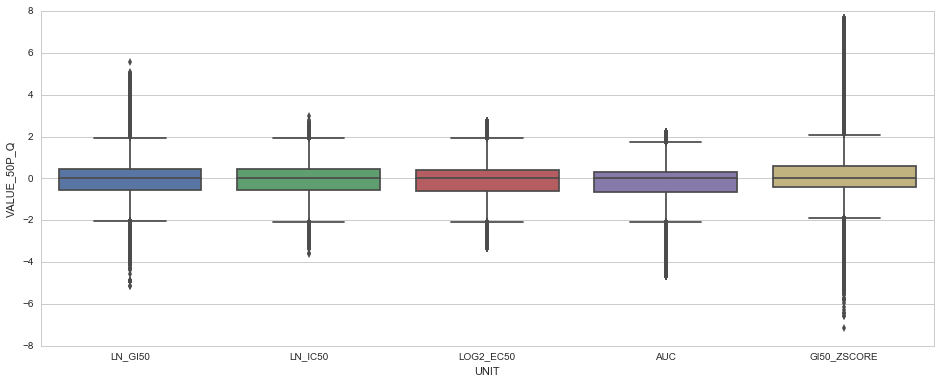

In [20]:
plt.figure(figsize=(16,6))
sns.boxplot(
    x='UNIT', y='VALUE_50P_Q', #y='VALUE_MEAN_Z'
    data=d_drug_agg\
        .assign(MEASURE_NAME=d_drug_agg['SOURCE']\
        .str.cat(d_drug_agg['UNIT'], sep=' '))
)

## Export

In [21]:
d_exp = d_drug_ext.copy()
d_exp['SOURCE_NAME'] = d_exp['SOURCE'].apply(src.get_pretty_name)
sql_export.export_sql_db(d_exp, 'drug_sensitivity_replicate_data', 'mgds', export_csv=True)

2016-12-11 08:20:45,853:INFO:mgds.data_aggregation.export_lib.sql_export: Successfully exported data to table "drug_sensitivity_replicate_data" at database path "sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db"


'sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db'

In [22]:
d_exp = d_drug_agg.copy()
d_exp['SOURCE_NAME'] = d_exp['SOURCE'].apply(src.get_pretty_name)
sql_export.export_sql_db(d_exp, 'drug_sensitivity_summary_data', 'mgds', export_csv=True)

2016-12-11 08:22:49,814:INFO:mgds.data_aggregation.export_lib.sql_export: Successfully exported data to table "drug_sensitivity_summary_data" at database path "sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db"


'sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db'

In [23]:
d_exp = d_rx.stack(level=[0,1]).rename('DRUG_NAME:SOURCE').reset_index()
d_exp['SOURCE_NAME'] = d_exp['SOURCE'].apply(src.get_pretty_name)
sql_export.export_sql_db(d_exp, 'drug_name_mappings', 'mgds', export_csv=True)
d_exp.info()

2016-12-11 08:22:50,155:INFO:mgds.data_aggregation.export_lib.sql_export: Successfully exported data to table "drug_name_mappings" at database path "sqlite:////Users/eczech/data/research/mgds/export/superset/mgds.db"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14293 entries, 0 to 14292
Data columns (total 5 columns):
DRUG_NAME:MGDS      14293 non-null object
TAXONOMY            14293 non-null object
SOURCE              14293 non-null object
DRUG_NAME:SOURCE    14293 non-null object
SOURCE_NAME         14293 non-null object
dtypes: object(5)
memory usage: 558.4+ KB


# Analysis

In [455]:
d_drug_src.head()

,SOURCE,UNIT,VALUE_50P_N,VALUE_50P_MIN,VALUE_50P_75P,VALUE_50P_MAX,VALUE_50P_50P,VALUE_50P_IQR,VALUE_50P_25P,VALUE_MEAN_N,VALUE_MEAN_MIN,VALUE_MEAN_STD,VALUE_MEAN_MAX,VALUE_MEAN_VLO,VALUE_MEAN_MEAN,VALUE_MEAN_VHI
0,ctd_v2,AUC,387130,0.069100,14.582000,20.000000,13.440000,2.974000,11.608000,387130,0.069100,2.618332,20.000000,10.145964,12.764293,15.382621
1,ctd_v2,LOG2_EC50,387130,-20.000000,4.726000,20.000000,1.961000,6.581000,-1.855000,387130,-20.000000,7.976799,20.000000,-7.058687,0.918101,8.894890
2,gdsc_v2,AUC,205148,0.003433,0.976656,0.998639,0.926490,0.197119,0.779537,205148,0.003433,0.197195,0.998639,0.642660,0.839854,1.037048
3,gdsc_v2,LN_IC50,205148,-9.971900,4.001928,12.802280,2.499141,3.447873,0.554055,205148,-9.971900,2.748047,12.802280,-0.715225,2.032815,4.780856
4,nci60_v2,GI50_ZSCORE,232479,-7.350000,0.480000,7.620000,-0.120000,1.010000,-0.530000,232479,-7.350000,0.953107,7.620000,-0.953805,-0.000700,0.952405


In [32]:
source_statistic = 'VALUE_50P_Q' # VALUE_50P_Q VALUE_MEAN_Z
source_agg_fn = lambda df: df.median(axis=1) # df.median(axis=1) df.mean(axis=1)

dt = d_drug_agg.copy()

dt = dt.set_index(['DRUG_NAME:MGDS', 'CELL_LINE_ID:MGDS', 'UNIT', 'SOURCE'])[source_statistic]
dt = dt.unstack().unstack()
c_measure = [
    (src.CTD_v2, 'LOG2_EC50'), (src.GDSC_v2, 'LN_IC50'), #(src.NCI60_v2, 'GI50_ZSCORE'),
    (src.CTD_v2, 'AUC'), (src.GDSC_v2, 'AUC'), (src.NCI60_v2, 'LN_GI50')
]
dt = dt[c_measure]
dt['N_VALUES'] = dt.notnull().sum(axis=1).astype(str)
dt = dt.set_index('N_VALUES', append=True)
dt.index = dt.index.swaplevel(i=-1, j=-3)

dt[('all', 'MEAN')] = source_agg_fn(dt[c_measure])
for c in c_measure:
    dt[(c[0], c[1]+':diff')] = dt[c] - dt[('all', 'MEAN')]
dt.columns = [':'.join(c) for c in dt.columns]
dt.head()

ctd_v2:LOG2_EC50  gdsc_v2:LN_IC50  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                                      
1        7860              010200                       NaN              NaN   
         A498              010200                       NaN              NaN   
         A549ATCC          010200                       NaN              NaN   
         ACHN              010200                       NaN              NaN   
         BT549             010200                       NaN              NaN   

                                           ctd_v2:AUC  gdsc_v2:AUC  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                            
1        7860              010200                 NaN          NaN   
         A498              010200                 NaN          NaN   
         A549ATCC          010200                 NaN          NaN   
         ACHN              010200                 NaN          NaN   
         BT549             010200                 NaN          NaN   

                                           nci60_v2:LN_GI50  all:MEAN  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                               
1        7860              010200                  0.831126  0.831126   
         A498              010200                  1.152318  1.152318   
         A549ATCC          010200                  1.072848  1.072848   
         ACHN              010200                  1.076159  1.076159   
         BT549             010200                  0.860927  0.860927   

                                           ctd_v2:LOG2_EC50:diff  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                          
1        7860              010200                            NaN   
         A498              010200                            NaN   
         A549ATCC          010200                            NaN   
         ACHN              010200                            NaN   
         BT549             010200                            NaN   

                                           gdsc_v2:LN_IC50:diff  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                         
1        7860              010200                           NaN   
         A498              010200                           NaN   
         A549ATCC          010200                           NaN   
         ACHN              010200                           NaN   
         BT549             010200                           NaN   

                                           ctd_v2:AUC:diff  gdsc_v2:AUC:diff  \
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                                      
1        7860              010200                      NaN               NaN   
         A498              010200                      NaN               NaN   
         A549ATCC          010200                      NaN               NaN   
         ACHN              010200                      NaN               NaN   
         BT549             010200                      NaN               NaN   

                                           nci60_v2:LN_GI50:diff  
N_VALUES CELL_LINE_ID:MGDS DRUG_NAME:MGDS                         
1        7860              010200                            0.0  
         A498              010200                            0.0  
         A549ATCC          010200                            0.0  
         ACHN              010200                            0.0  
         BT549             010200                            0.0

In [33]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 786155 entries, (1, 7860, 010200) to (1, UO31, ZYGOSPORINA)
Data columns (total 11 columns):
ctd_v2:LOG2_EC50         387130 non-null float64
gdsc_v2:LN_IC50          205148 non-null float64
ctd_v2:AUC               387130 non-null float64
gdsc_v2:AUC              205148 non-null float64
nci60_v2:LN_GI50         232479 non-null float64
all:MEAN                 785130 non-null float64
ctd_v2:LOG2_EC50:diff    387130 non-null float64
gdsc_v2:LN_IC50:diff     205148 non-null float64
ctd_v2:AUC:diff          387130 non-null float64
gdsc_v2:AUC:diff         205148 non-null float64
nci60_v2:LN_GI50:diff    232479 non-null float64
dtypes: float64(11)
memory usage: 72.0+ MB


In [35]:
dt.loc[str(len(c_measure))].filter(regex='diff').iplot(kind='box')

In [36]:
dt.loc[str(len(c_measure))].filter(regex='diff').iplot(kind='histogram', bins=100)

In [37]:
dt[dt.index.get_level_values('DRUG_NAME:MGDS') == 'NAVITOCLAX']\
    .filter(regex='^(?!.*diff)').sort_values('all:MEAN').iplot(mode='markers', size=3)

In [38]:
dt.loc[str(len(c_measure))].filter(regex='^(?!.*diff)').sort_values('all:MEAN').iplot(mode='markers', size=3)

In [39]:
dt2 = dt.loc[str(len(c_measure))].filter(regex='^(?!.*diff)').sort_values('all:MEAN')
y = dt2['all:MEAN']
y_std = dt2.filter(regex='^(?!.*:MEAN)').std(axis=1)
pd.DataFrame({
    'Average': y, 
    'Average + 1 STD': (y + y_std).rolling(center=True, window=5).mean(), 
    'Average - 1 STD': (y - y_std).rolling(center=True, window=5).mean()
}).iplot()

In [44]:
dt = d_drug_agg.copy()
def agg(v):
    assert len(v) == 1
    return v.iloc[0]
dt = dt.set_index(['DRUG_NAME:MGDS', 'CELL_LINE_ID:MGDS', 'UNIT', 'SOURCE'])['VALUE_50P_Q']
dt = dt.unstack().unstack().dropna(how='all', axis=1)
dt.columns = [':'.join(c) for c in dt]
dt.head()

ctd_v2:AUC  ctd_v2:LOG2_EC50  gdsc_v2:AUC  \
DRUG_NAME:MGDS CELL_LINE_ID:MGDS                                              
010200         7860                      NaN               NaN          NaN   
               A498                      NaN               NaN          NaN   
               A549ATCC                  NaN               NaN          NaN   
               ACHN                      NaN               NaN          NaN   
               BT549                     NaN               NaN          NaN   

                                  gdsc_v2:LN_IC50  nci60_v2:GI50_ZSCORE  \
DRUG_NAME:MGDS CELL_LINE_ID:MGDS                                          
010200         7860                           NaN              1.950495   
               A498                           NaN             -0.861386   
               A549ATCC                       NaN             -0.198020   
               ACHN                           NaN             -0.198020   
               BT549                          NaN              1.702970   

                                  nci60_v2:LN_GI50  ncidream_v1:LN_GI50  
DRUG_NAME:MGDS CELL_LINE_ID:MGDS                                         
010200         7860                       0.831126                  NaN  
               A498                       1.152318                  NaN  
               A549ATCC                   1.072848                  NaN  
               ACHN                       1.076159                  NaN  
               BT549                      0.860927                  NaN

In [45]:
dt.notnull().sum(axis=1).sort_values(ascending=False).head(10)

DRUG_NAME:MGDS  CELL_LINE_ID:MGDS
DOXORUBICIN     HS578T               7
                MCF7                 7
                T47D                 7
                MDAMB231             7
ETOPOSIDE       OVCAR4               6
NILOTINIB       SF268                6
TEMSIROLIMUS    NCIH226              6
ETOPOSIDE       OVCAR8               6
                OVCAR5               6
TEMSIROLIMUS    SKOV3                6
dtype: int64

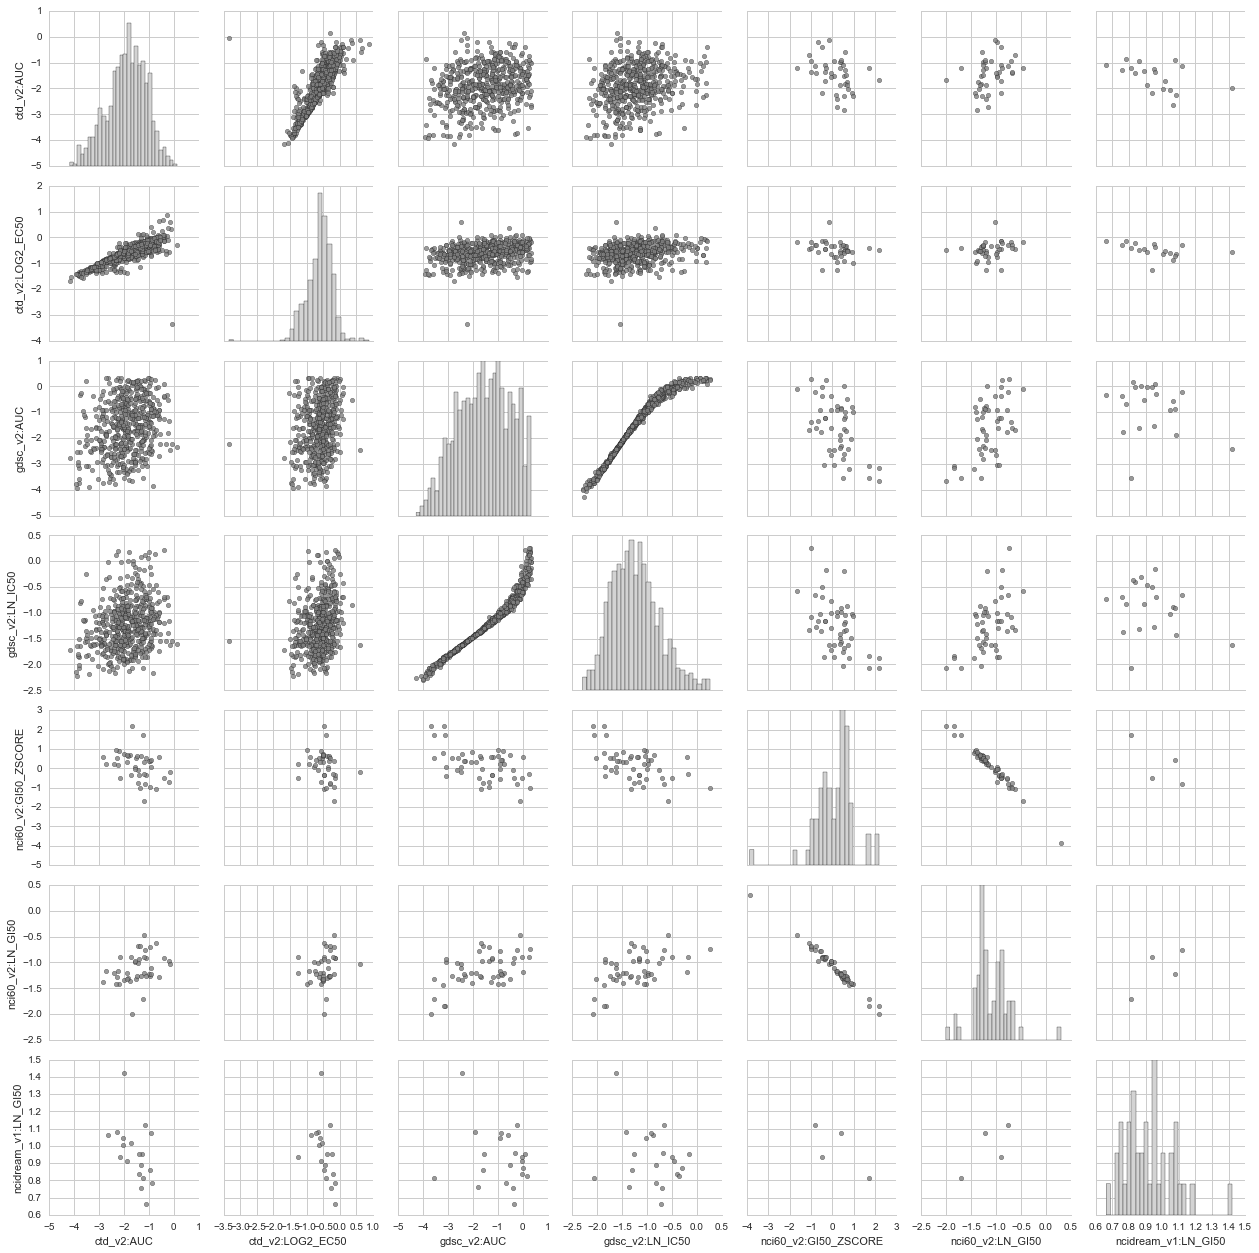

In [46]:
drug_name = 'DOXORUBICIN'

def plot_scatter(x, y, **kwargs):
    is_na = x.isnull() | y.isnull()
    return plt.scatter(x[~is_na], y[~is_na], alpha=.8, c='grey')

def plot_diag(x, **kwargs):
    return plt.hist(x.dropna(), bins=30, color='lightgrey')

g = sns.PairGrid(dt.loc[drug_name], diag_sharey=False)
g.map_offdiag(plot_scatter)
g.map_diag(plot_diag)

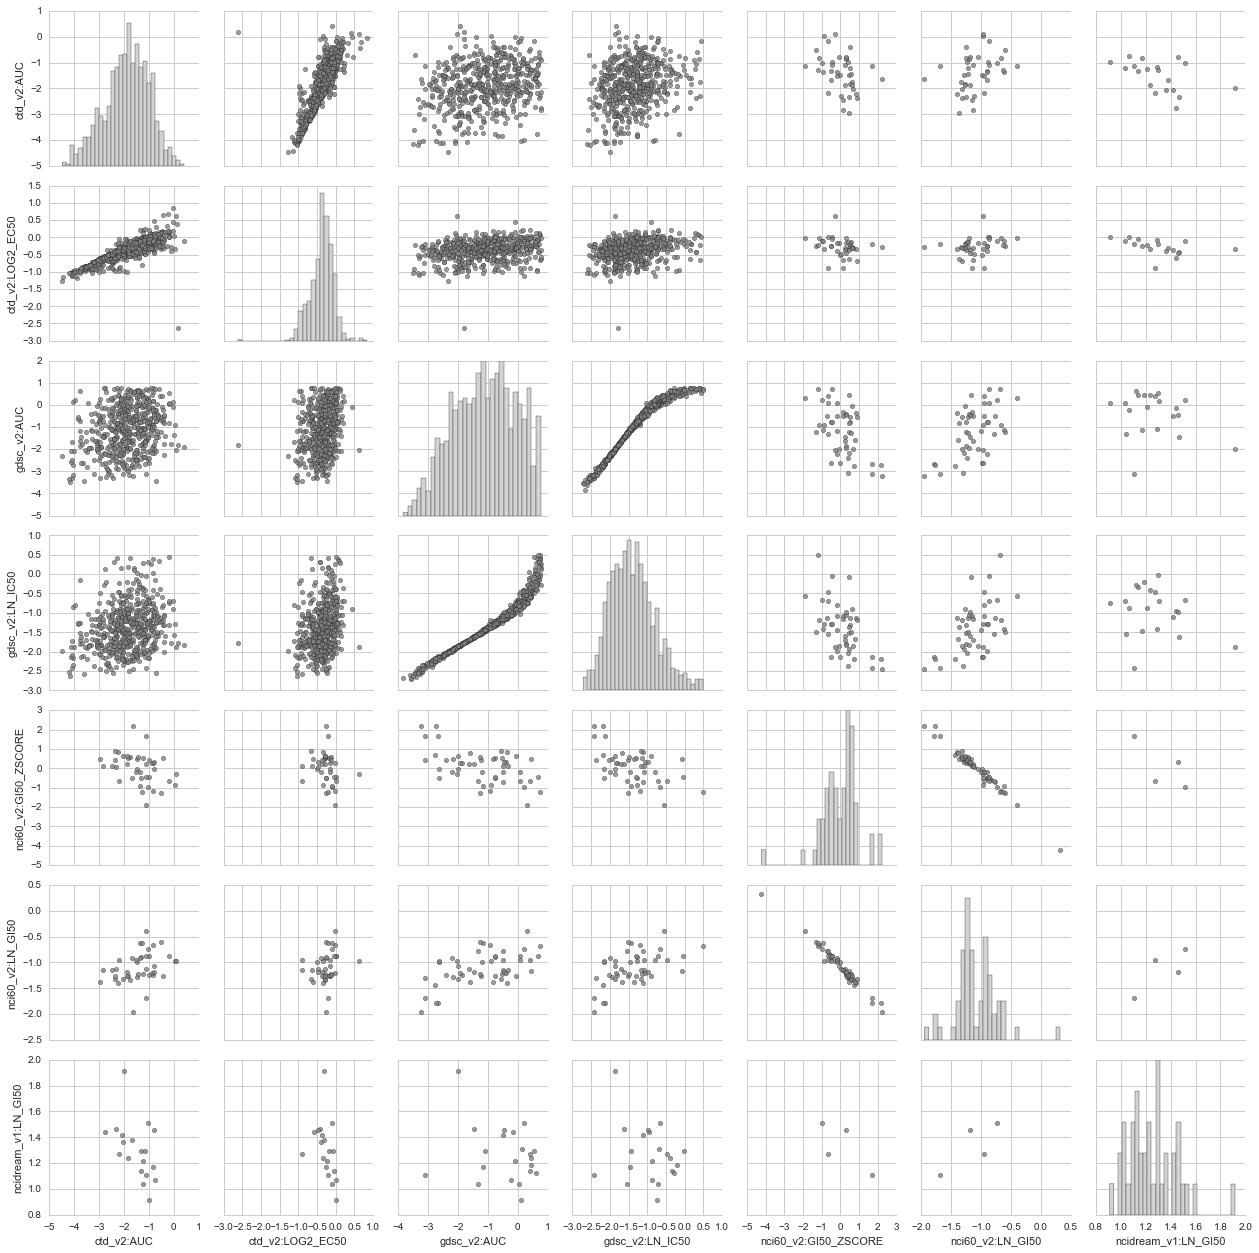

In [43]:
drug_name = 'DOXORUBICIN'

def plot_scatter(x, y, **kwargs):
    is_na = x.isnull() | y.isnull()
    return plt.scatter(x[~is_na], y[~is_na], alpha=.8, c='grey')

def plot_diag(x, **kwargs):
    return plt.hist(x.dropna(), bins=30, color='lightgrey')

g = sns.PairGrid(dt.loc[drug_name], diag_sharey=False)
g.map_offdiag(plot_scatter)
g.map_diag(plot_diag)